Description

In this book I look at implementation of Random Trees and Random Forests using SKLearn and XGBoost
Using sample of medical data from the course I compile models and calculate their accuracy:

* classification using a tree (sklearn)
* classification using a forest (sklearn)
* dynamically finding best parameters for a model in sklearn
* classification using a forest (xgboost)

In [35]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Classification

Read inputs

In [36]:
data = pd.read_csv("./data_w4_heart.csv", delimiter=",")
data.describe(include="all")

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918,918,918.000000,918.000000,918.000000,918,918.000000,918,918.000000,918,918.000000
unique,NaN,2,4,NaN,NaN,NaN,3,NaN,2,NaN,3,NaN
top,NaN,M,ASY,NaN,NaN,NaN,Normal,NaN,N,NaN,Flat,NaN
freq,NaN,725,496,NaN,NaN,NaN,552,NaN,547,NaN,460,NaN
mean,53.510893,NaN,NaN,132.396514,198.799564,0.233115,NaN,136.809368,NaN,0.887364,NaN,0.553377
std,9.432617,NaN,NaN,18.514154,109.384145,0.423046,NaN,25.460334,NaN,1.066570,NaN,0.497414
min,28.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,60.000000,NaN,-2.600000,NaN,0.000000
25%,47.000000,NaN,NaN,120.000000,173.250000,0.000000,NaN,120.000000,NaN,0.000000,NaN,0.000000
50%,54.000000,NaN,NaN,130.000000,223.000000,0.000000,NaN,138.000000,NaN,0.600000,NaN,1.000000
75%,60.000000,NaN,NaN,140.000000,267.000000,0.000000,NaN,156.000000,NaN,1.500000,NaN,1.000000


Categorical to numerical

In [37]:
categorical_columns = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
df_with_dummies = pd.get_dummies(data,
                                 prefix=categorical_columns,
                                 columns=categorical_columns)
df_with_dummies

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0
914,68,144,193,1,141,3.4,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0
916,57,130,236,0,174,0.0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0


Split train and validation

In [38]:
x_ = df_with_dummies.drop(columns=['HeartDisease'])
y_ = df_with_dummies['HeartDisease']

x_.shape, y_.shape

((918, 20), (918,))

In [39]:
x_train, x_val, y_train, y_val = train_test_split(x_, y_, train_size=0.8, random_state=55)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((734, 20), (184, 20), (734,), (184,))

# Decision Tree (sklearn)

## Analysis of min samples in a node

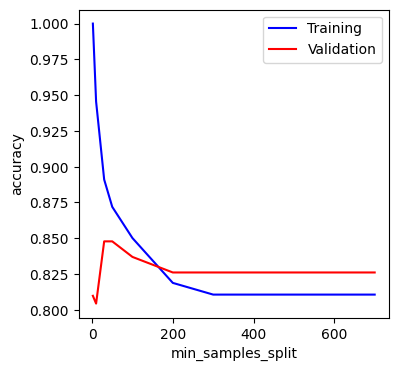

In [46]:
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,

accuracy_train = []
accuracy_val = []

for i in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split=i,
                                   random_state=55)
    model.fit(x_train, y_train)
    prediction = model.predict(x_val) >= 0.5
    accuracy_val.append(np.mean(prediction == y_val))
    prediction = model.predict(x_train) >= 0.5
    accuracy_train.append(np.mean(prediction == y_train))

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(min_samples_split_list, accuracy_train, c='b')
ax.plot(min_samples_split_list, accuracy_val, c='r')
ax.set_xlabel("min_samples_split")
ax.set_ylabel("accuracy")
plt.legend(['Training','Validation'])

Conclusion

At the minimum samples at internal node (left) we see overfitting, but increasing samples will reduce it. Ideal N samples = 50

## Analysis of max depth

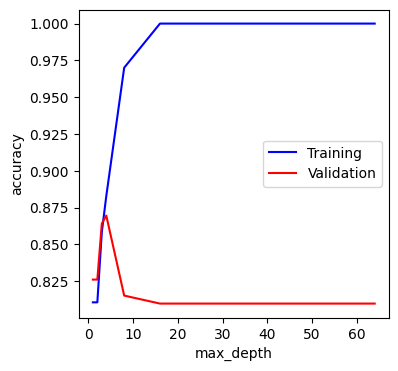

In [53]:
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

accuracy_train = []
accuracy_val = []

for i in max_depth_list:
    model = DecisionTreeClassifier(max_depth=i,
                                   random_state=55)
    model.fit(x_train, y_train)
    prediction = model.predict(x_val) >= 0.5
    accuracy_val.append(np.mean(prediction == y_val))
    prediction = model.predict(x_train) >= 0.5
    accuracy_train.append(np.mean(prediction == y_train))

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(max_depth_list, accuracy_train, c='b')
ax.plot(max_depth_list, accuracy_val, c='r')
ax.set_xlabel("max_depth")
ax.set_ylabel("accuracy")
plt.legend(['Training','Validation'])

Conclusion
Reducing max_depth reduces overfitting, ideal range = 3-4

## Resulting model

In [55]:
single_tree_model = DecisionTreeClassifier(min_samples_split=50, max_depth=3, random_state=55)
single_tree_model.fit(x_train, y_train)
prediction = single_tree_model.predict(x_train) >= 0.5
print(f"accuracy on train = {np.mean(prediction==y_train)}")
prediction = single_tree_model.predict(x_val) >= 0.5
print(f"accuracy on validation = {np.mean(prediction==y_val)}")

accuracy on train = 0.8583106267029973
accuracy on validation = 0.8641304347826086


# Random Forest (sklearn)

## Analysis of min samples in a node

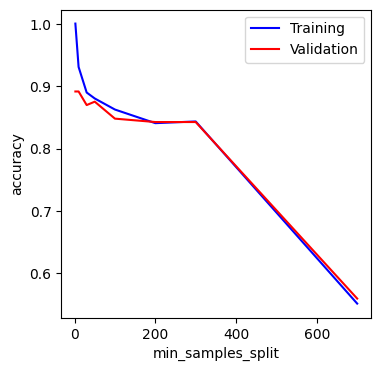

In [58]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset

accuracy_train = []
accuracy_val = []

for i in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split=i,
                                   random_state=55)
    model.fit(x_train, y_train)
    prediction = model.predict(x_val) >= 0.5
    accuracy_val.append(np.mean(prediction == y_val))
    prediction = model.predict(x_train) >= 0.5
    accuracy_train.append(np.mean(prediction == y_train))

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(min_samples_split_list, accuracy_train, c='b')
ax.plot(min_samples_split_list, accuracy_val, c='r')
ax.set_xlabel("min_samples_split")
ax.set_ylabel("accuracy")
plt.legend(['Training','Validation'])


Conclusion

Increasing min samples reduce overfitting

## Analysis of max depth

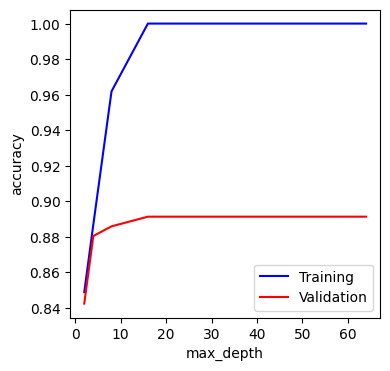

In [61]:
max_depth_list = [2, 4, 8, 16, 32, 64, None]

accuracy_train = []
accuracy_val = []

for i in max_depth_list:
    model = RandomForestClassifier(max_depth=i,
                                   random_state=55)
    model.fit(x_train, y_train)
    prediction = model.predict(x_val) >= 0.5
    accuracy_val.append(np.mean(prediction == y_val))
    prediction = model.predict(x_train) >= 0.5
    accuracy_train.append(np.mean(prediction == y_train))

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(max_depth_list, accuracy_train, c='b')
ax.plot(max_depth_list, accuracy_val, c='r')
ax.set_xlabel("max_depth")
ax.set_ylabel("accuracy")
plt.legend(['Training','Validation'])

Conclusion

Increasing max depth we prone to overfit. Ideal value = 16 (see lection, they had a different value due to random selection)

## Analysis of n_estimators

n_estimators is the number of Decision Trees that make up the Random Forest.

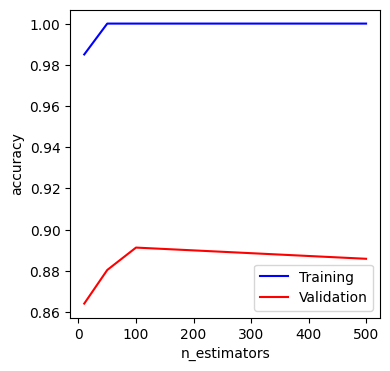

In [62]:
n_estimators_list = [10,50,100,500]

accuracy_train = []
accuracy_val = []

for i in n_estimators_list:
    model = RandomForestClassifier(n_estimators=i,
                                   random_state=55)
    model.fit(x_train, y_train)
    prediction = model.predict(x_val) >= 0.5
    accuracy_val.append(np.mean(prediction == y_val))
    prediction = model.predict(x_train) >= 0.5
    accuracy_train.append(np.mean(prediction == y_train))

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(n_estimators_list, accuracy_train, c='b')
ax.plot(n_estimators_list, accuracy_val, c='r')
ax.set_xlabel("n_estimators")
ax.set_ylabel("accuracy")
plt.legend(['Training','Validation'])

Conclusion

By increasing the number of trees we are not profiting after 100.

## Resulting model

 - max_depth: 16
 - min_samples_split: 10
 - n_estimators: 100


In [64]:
accuracy_train = []
accuracy_val = []

model = RandomForestClassifier(min_samples_split=10,
                               max_depth=16,
                               n_estimators=100,
                                random_state=55)
model.fit(x_train, y_train)

prediction = model.predict(x_train) >= 0.5
print(f"Train accuracy: {np.mean(prediction == y_train)}")

prediction = model.predict(x_val) >= 0.5
print(f"Validation accuracy: {np.mean(prediction == y_val)}")


Train accuracy: 0.9305177111716622
Validation accuracy: 0.8913043478260869


# Hyperparameters auto selection

Above, we just held other hyperparametners at their default value while testing one specific aspect.
However, this is not ideal as all combinations need to be tested.
This can be implemented using sklearn GridSearchCV

In [66]:
from sklearn.model_selection import GridSearchCV

min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

params = {'min_samples_split':min_samples_split_list,
          'max_depth':max_depth_list,
          'n_estimators':n_estimators_list}

model = RandomForestClassifier()

search = GridSearchCV(model, params)
search.fit(x_train, y_train)
sorted(search.cv_results_.keys())


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

Extract cv_results_

In [96]:
scores_min_samples_split = np.array(search.cv_results_['param_min_samples_split'])
scores_max_depth = np.array(search.cv_results_['param_max_depth'])
scores_n_estimators = np.array(search.cv_results_['param_n_estimators'])
mean_test_score =np.array(search.cv_results_['mean_test_score'])
rank_test_score =np.array(search.cv_results_['rank_test_score'])

index_best_params = np.where(rank_test_score == 1)

print(f"Best mean = {mean_test_score[index_best_params]} in parameters:")
print(f"scores_min_samples_split = {scores_min_samples_split[index_best_params]}")
print(f"scores_max_depth = {scores_max_depth[index_best_params]}")
print(f"scores_n_estimators = {scores_n_estimators[index_best_params]}")


Best mean = [0.87185724] in parameters:
scores_min_samples_split = [30]
scores_max_depth = [8]
scores_n_estimators = [10]


Plot

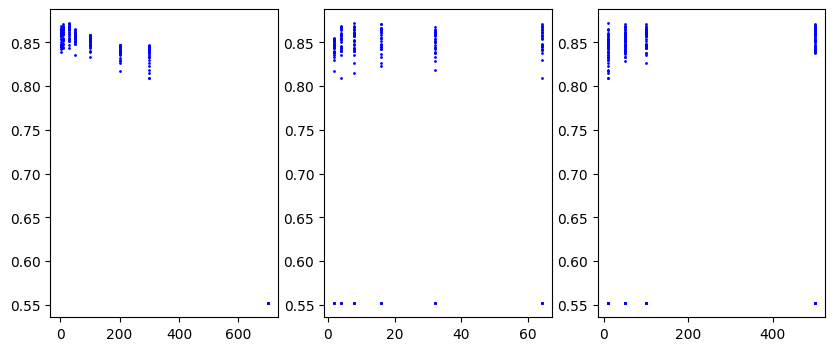

In [105]:
best_score_min_samples = int(scores_min_samples_split[index_best_params])
best_score_max_depth = int(scores_max_depth[index_best_params])
best_n_estimaters = int(scores_n_estimators[index_best_params])

fig, ax = plt.subplots(1,3, figsize=(10,4))
ax[0].scatter(scores_min_samples_split, mean_test_score, c='b', s=1)
ax[1].scatter(scores_max_depth, mean_test_score, c='b', s=1)
ax[2].scatter(scores_n_estimators, mean_test_score, c='b', s=1)

# xgboost - Random Forest

Difference against numpy

Gradient Boosting model, called XGBoost. The boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fit one after the other in order to minimize the error.

The model has the same parameters as a decision tree, plus the learning rate.

* The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

One interesting thing about the XGBoost is that during fitting, it can take in an evaluation dataset of the form (X_val,y_val).
* On each iteration, it measures the cost (or evaluation metric) on the evaluation datasets.
* Once the cost (or metric) stops decreasing for a number of rounds (called early_stopping_rounds), the training will stop.
* More iterations lead to more estimators, and more estimators can result in overfitting.
* By stopping once the validation metric no longer improves, we can limit the number of estimators created, and reduce overfitting.

Additional evaluation set

In [112]:
n = int(len(x_train) * 0.8)
x_train_fit, x_train_eval = x_train[:n], x_train[n:]
y_train_fit, y_train_eval = y_train[:n], y_train[n:]

x_train_fit.shape, x_train_eval.shape, y_train_fit.shape, y_train_eval.shape

/var/folders/nr/pxyxhh4s2vl120p6__1g3z2c0000gn/T/ipykernel_8826/2976908532.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train_fit, y_train_eval = y_train[:n], y_train[n:]


((587, 20), (147, 20), (587,), (147,))

In [115]:
model = XGBClassifier(n_estimators=500, learning_rate = 0.1, verbosity = 1, random_state = 55)

model.fit(x_train_fit, y_train_fit
          , eval_set = [(x_train_eval,y_train_eval)]
          , early_stopping_rounds = 10)


[0]	validation_0-logloss:0.64479
[1]	validation_0-logloss:0.60569
[2]	validation_0-logloss:0.57481
[3]	validation_0-logloss:0.54947
[4]	validation_0-logloss:0.52973


[5]	validation_0-logloss:0.51331
[6]	validation_0-logloss:0.49823
[7]	validation_0-logloss:0.48855
[8]	validation_0-logloss:0.47888
[9]	validation_0-logloss:0.47068
[10]	validation_0-logloss:0.46507
[11]	validation_0-logloss:0.45832
[12]	validation_0-logloss:0.45557
[13]	validation_0-logloss:0.45030
[14]	validation_0-logloss:0.44653
[15]	validation_0-logloss:0.44213
[16]	validation_0-logloss:0.43948
[17]	validation_0-logloss:0.44088
[18]	validation_0-logloss:0.44358
[19]	validation_0-logloss:0.44493
[20]	validation_0-logloss:0.44294
[21]	validation_0-logloss:0.44486
[22]	validation_0-logloss:0.44586
[23]	validation_0-logloss:0.44680
[24]	validation_0-logloss:0.44925
[25]	validation_0-logloss:0.45383
[26]	validation_0-logloss:0.45547


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=55, ...)

In [117]:
model.best_iteration # algo above stopped at best iteration + early_stopping_rounds

16

## Prediction and accuracy

In [122]:
print(f"Prediction Accuracy")

prediction = model.predict(x_train)
print(f"\ton Train set = {np.mean(prediction==y_train)}")

prediction = model.predict(x_val)
print(f"\ton Validation set = {np.mean(prediction==y_val)}")

Prediction Accuracy
	on Train set = 0.9250681198910081
	on Validation set = 0.8641304347826086
